In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from IPython.display import display,Image
from rdkit.Chem.Draw import rdMolDraw2D

# Docking screening for potential D3R receptor inhibitors   
This notebook provides the workflow for the analysis of docking data obtained from Vina and iDock. 

- [Results for docking of reference: scaffold and eticlopride](#section1)
- [Autodock Vina summary](#section2)
- [iDock summary](#section3)
- [Vina vs iDock comparison](#section4)
- [Selection of best binders](#section5)

<a id='section1'></a>
## Results for docking of reference: scaffold and eticlopride   
The docking was done using the script run_docking_reference.py  

In [32]:
epq_vina = np.array([-7.793, -7.115,-8.006])
scaf_vina = np.array([-7.774, -7.68, -7.751])

epq_idock = np.array([-8.01, -7.84, -8.08])
scaf_idock = np.array([-7.73, -7.69, -7.79])

print(f'According to Vina:')
print(f'etclopride {epq_vina.mean().round(2)} (std {epq_vina.std().round(2)}),')
print(f' scaffold {scaf_vina.mean().round(2)} (std {scaf_vina.std().round(2)})')
print()
print(f'According to iDock:')
print(f'etclopride {epq_idock.mean().round(2)} (std {epq_idock.std().round(2)}),')
print(f' scaffold {scaf_idock.mean().round(2)} (std {scaf_idock.std().round(2)})')

According to Vina:
etclopride -7.64 (std 0.38),
 scaffold -7.74 (std 0.04)

According to iDock:
etclopride -7.98 (std 0.1),
 scaffold -7.74 (std 0.04)


<a id='section2'></a>
## Autodock Vina summary

In [2]:
# load dataset with compounds for subsequent use
click_library = pd.read_csv('./data/click_compunds_dataset.csv', index_col=0)
click_library.head()

,id,smiles,is_14isomer,logBBclark,logBBrishton,group_clark,group_rishton,scaf_tanimoto,epq_tanimoto
0,1,COCCOCCOCC(=O)n1cc(CCCCN2CCN(c3ccccc3)CC2)nn1,1,-0.808954,-0.385366,0,0,0.400000,0.142857
1,2,COCCOCCOCC(=O)n1nncc1CCCCN1CCN(c2ccccc2)CC1,0,-0.808954,-0.385366,0,0,0.444444,0.142857
2,3,COC(=O)C(O)C(C)n1cc(CCCCN2CCN(c3ccccc3)CC2)nn1,1,-0.869335,-0.437926,0,0,0.400000,0.142857
3,4,COC(=O)C(O)C(C)n1nncc1CCCCN1CCN(c2ccccc2)CC1,0,-0.869335,-0.437925,0,0,0.444444,0.142857
4,5,CSCCC(NCCCn1cc(CCCCN2CCN(c3ccccc3)CC2)nn1)C(N)=O,1,-0.921714,-0.447596,0,0,0.351351,0.107843


In [3]:
# load and prepare Vina data
data_vina = pd.read_csv('./data/vina_data.csv', index_col=0)
print(data_vina.shape)
data_vina = data_vina[data_vina['affinity'] != 0] # drop missing compounds
print(data_vina.shape)

# aggregate using mean
mean = data_vina.groupby(['id', 'isomer'])['affinity'].mean().rename("affinity_mean")
std  = data_vina.groupby(['id', 'isomer'])['affinity'].std().rename("affinity_std")
data_vina = pd.DataFrame(mean).join(std).reset_index()

print(f"Found data for {data_vina.shape[0]} compounds")
data_vina.head()

(9186, 4)
(9048, 4)
Found data for 3016 compounds


,id,isomer,affinity_mean,affinity_std
0,31,14,-8.375333,0.113650
1,32,15,-8.795333,0.021385
2,37,14,-7.897333,0.042063
3,38,15,-8.383667,0.052176
4,55,14,-8.246667,0.136152


In [35]:
data_vina.describe()

,id,isomer,affinity_mean,affinity_std
count,3017.000000,3017.000000,3017.000000,3017.000000
mean,9499.428240,14.499834,-8.548493,0.101480
std,5474.149525,0.500083,0.539388,0.114566
min,31.000000,14.000000,-10.270000,0.000000
25%,4799.000000,14.000000,-8.958667,0.036497
50%,9351.000000,14.000000,-8.551667,0.071141
75%,14164.000000,15.000000,-8.171333,0.131286
max,18834.000000,15.000000,-6.404000,3.399039


In [36]:
# a function to draw a panel of molecules with labels

def draw_molecules(molecules, legends, title):
    # Annotates a MolsToGridImage given a set of labels for each mol with better font size options and title
    sub_img_size = 500
    annotation_size = 20
    title_size = 30
    y_offset = -1
    mols_per_row = 4

    img = Draw.MolsToGridImage(molecules,
                               molsPerRow=mols_per_row,
                               subImgSize=(sub_img_size, sub_img_size),
                               returnPNG=False)
    
    height = 6 * (len(molecules)//4 + (len(molecules)%4 > 0))

    fig, ax = plt.subplots(figsize=(24,height))
    plt.title(title, fontsize=title_size)
    text_pos = (sub_img_size / 2, sub_img_size + y_offset)

    pos_ctr = 0
    plt.axis("off")
    for cmpd_text in legends:
        plt.annotate(cmpd_text, text_pos, fontsize=20, horizontalalignment='center')
        pos_ctr += 1
        text_pos = (text_pos[0] + sub_img_size, text_pos[1])
        if (pos_ctr % mols_per_row) == 0:
            text_pos = (sub_img_size / 2, text_pos[1] + sub_img_size)

    ax.imshow(img, origin="upper")

### Also let's see molecules with failed docking

found 46 molecues


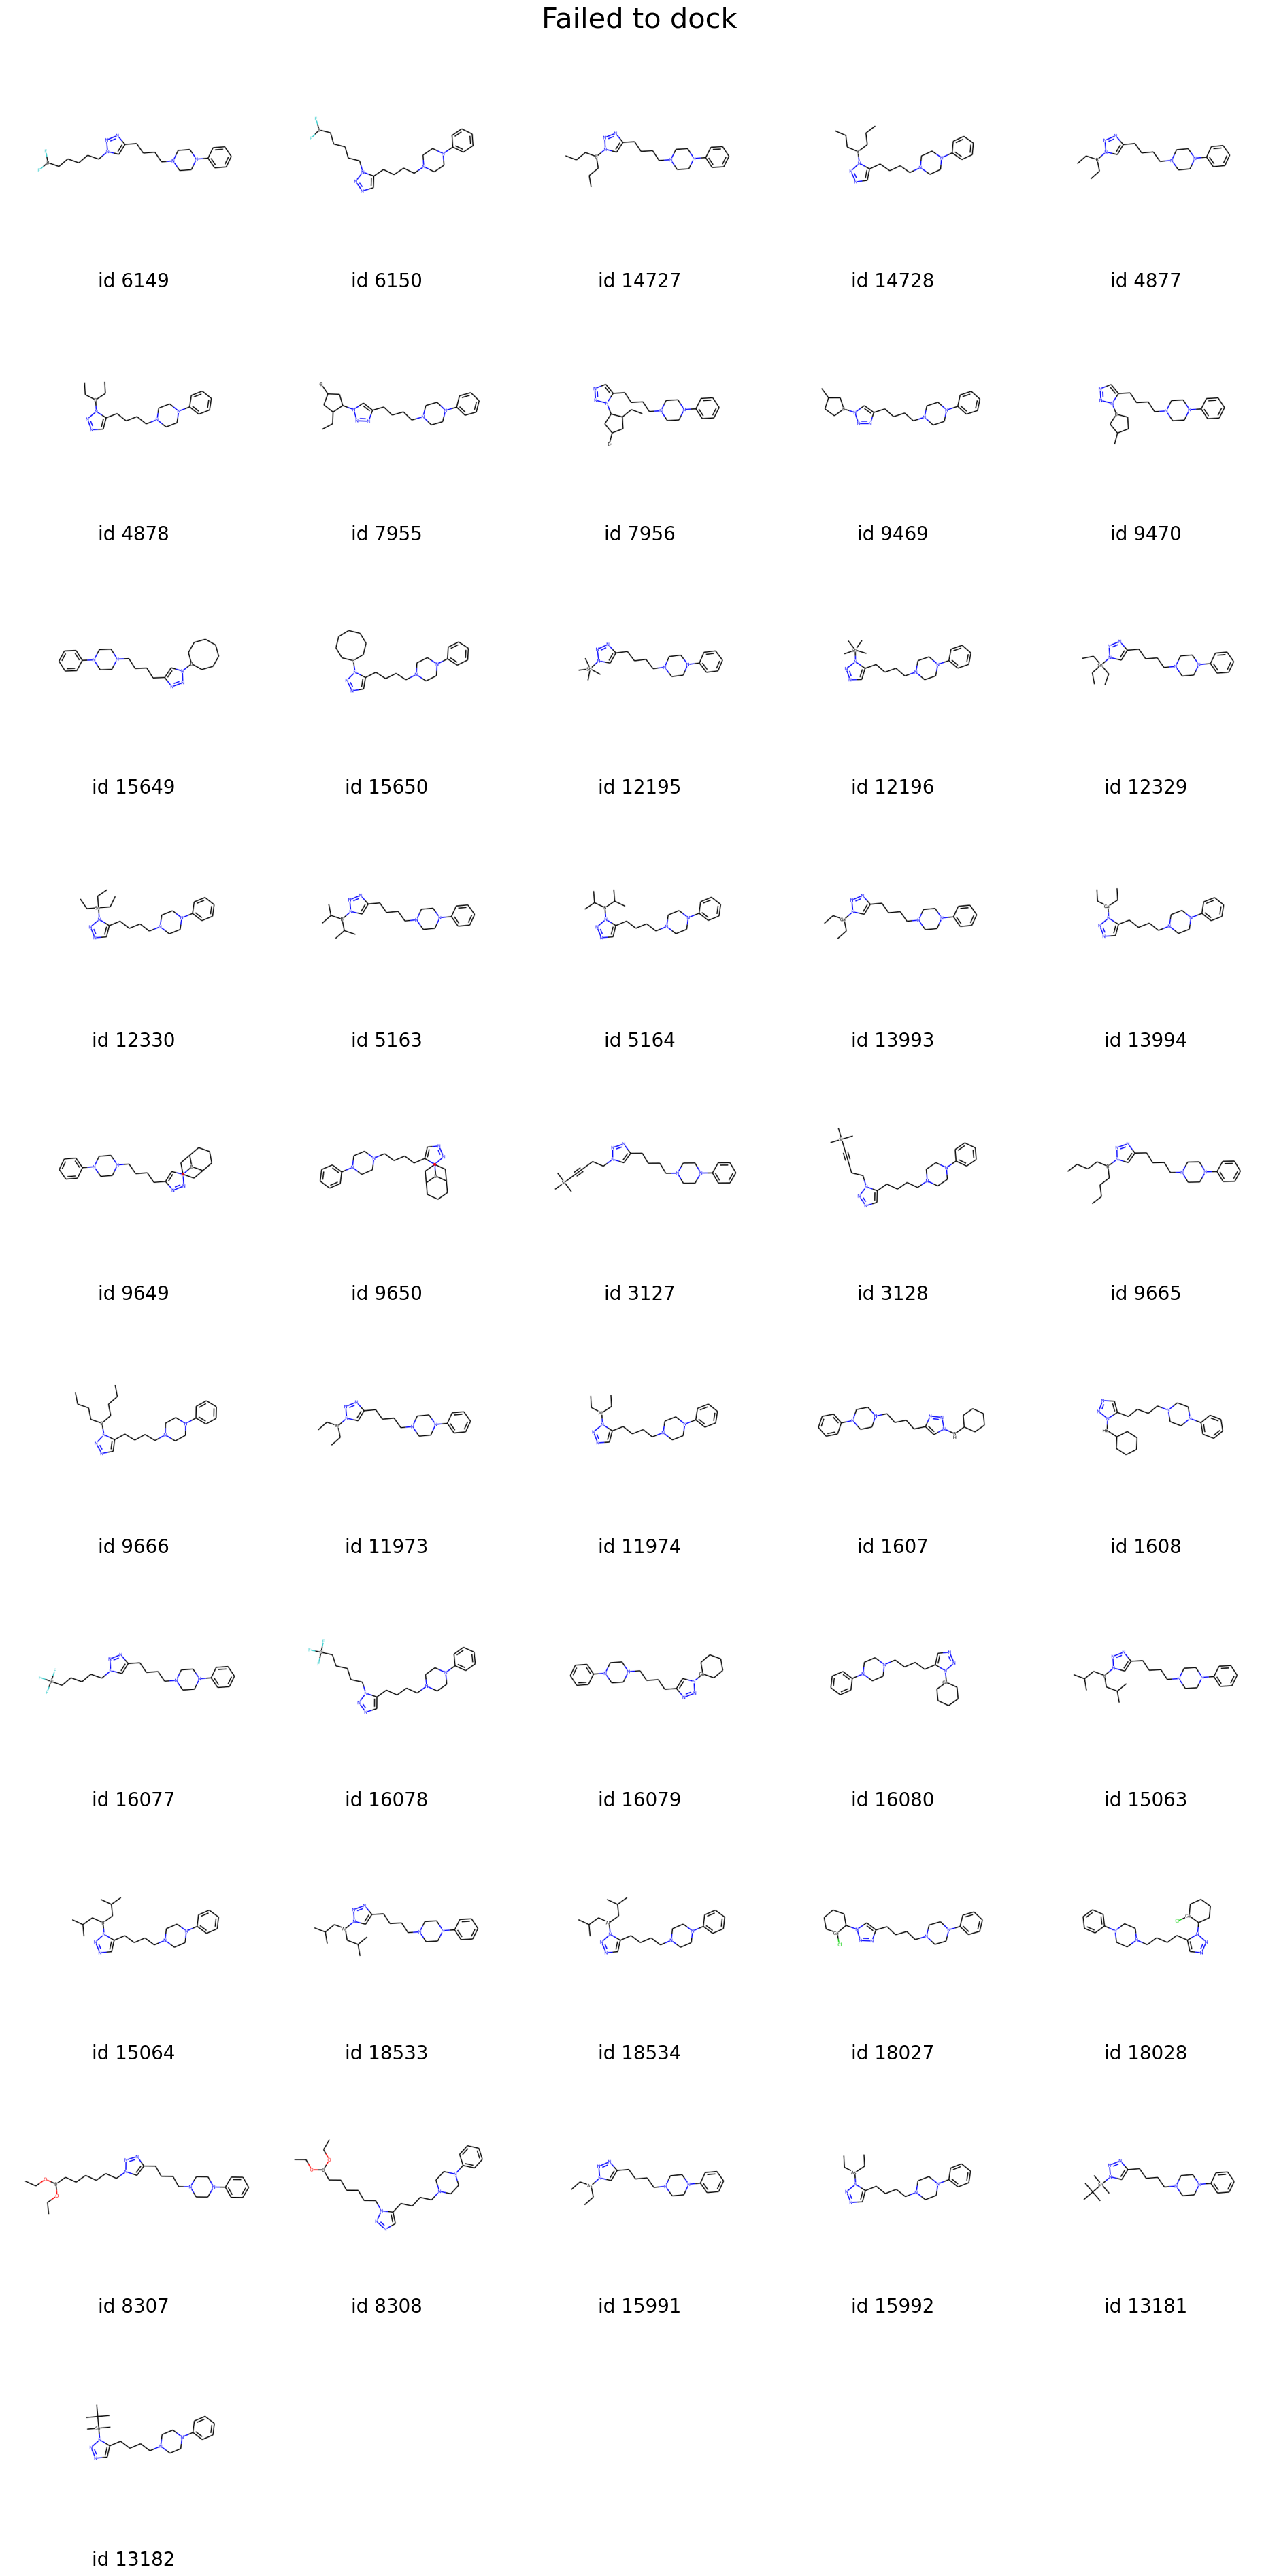

In [180]:
data = pd.read_csv('./data/vina_data.csv', index_col=0)
data_failed = data[data['affinity'] == 0] # drop missing compounds

# compounds with high energies
mol_id = list(set(data_failed['id']))
print(f"found {len(mol_id)} molecues")

# get molecules to draw 
molecules = [Chem.MolFromSmiles(smi) for smi in click_library[click_library['id'].isin(mol_id)]['smiles']]

# set legends
legends = [f'id {i}' for i in mol_id]

draw_molecules(molecules, legends, "Failed to dock")

#plt.savefig('undocked_by_vina.png', bbox_inches='tight', dpi=300)
plt.show()

**These compunds contain elements not parametrized in Vina**

### Plots:

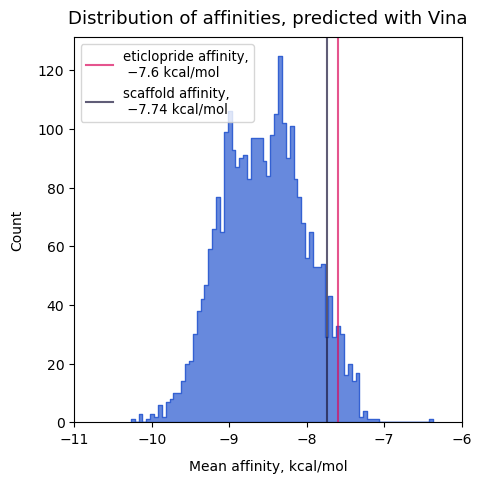

In [4]:
# plot destribution of Vina mean affinities

plt.figure(figsize=(5,5))

# lines representing eticlopide docking:  -7.6 +- 0.4
plt.axvline(x=-7.6, color='#da0c5e', alpha=0.7, label='eticlopride affinity,\n −7.6 kcal/mol')

# lines representing scaffold docking: -7.74 +- 0.04
plt.axvline(x=-7.74, color='#1c193d', alpha=0.7, label='scaffold affinity,\n −7.74 kcal/mol')

sns.histplot(data_vina['affinity_mean'], binwidth=0.05, color='#3461d2', element="step")

plt.xlabel("Mean affinity, kcal/mol", fontsize=10, labelpad=10) # Text for X-Axis
plt.ylabel("Count", fontsize=10, labelpad=10) # Text for Y-Axis
plt.title("Distribution of affinities, predicted with Vina", fontsize=13, pad=10)

plt.xlim(-11, -6)
plt.legend(loc = 'upper left', fontsize=9.5) # bbox_to_anchor=(1.1, 1.05)


# plt.savefig('vina_affinities_distplot.png', bbox_inches='tight', dpi=300)
plt.show()

230


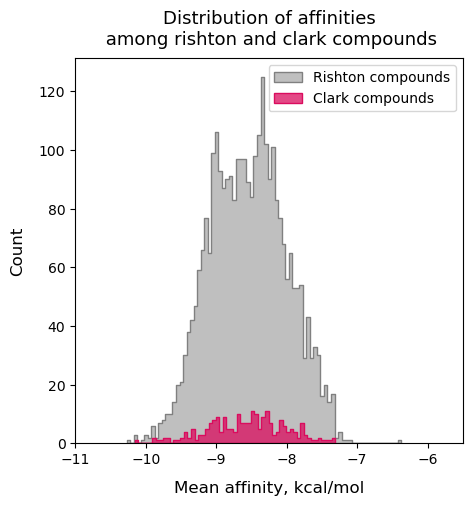

In [5]:
# hue destrubution by Clark and Rishton compounds

# get ids of clark compounds 
clark_id = list(click_library[click_library['group_clark'] == 1].id)
print(len(clark_id))

plt.figure(figsize=(5,5))

sns.histplot(data_vina['affinity_mean'], 
             color='grey', alpha=0.5, binwidth=0.05, element="step", label='Rishton compounds')


sns.histplot(data_vina[data_vina['id'].isin(clark_id)]['affinity_mean'],
             color='#da0c5e', binwidth=0.05, element="step", label='Clark compounds')


plt.xlabel("Mean affinity, kcal/mol", fontsize=12, labelpad=10) # Text for X-Axis
plt.ylabel("Count", fontsize=12, labelpad=10) # Text for Y-Axis
plt.title("Distribution of affinities\n among rishton and clark compounds", fontsize=13, pad=10)

plt.xlim(-11, -5.5)

plt.legend(loc='upper right')


# plt.savefig('vina_affinities_distplot_clark_vs_rishton.png', bbox_inches='tight', dpi=300)
plt.show()

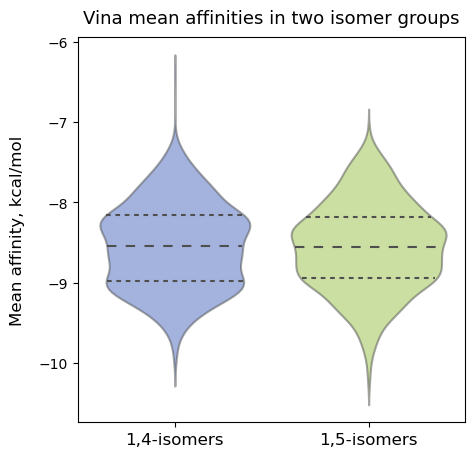

In [7]:
# compare affinities distributions for 1,4 and 1,5 isomers as violin plots

plt.figure(figsize=(5,5))

s = sns.violinplot(y='affinity_mean', x='isomer', data=data_vina,
               palette=['#3461d2', '#9fd432'], inner="quartile")

for violin in s.collections[::1]:
    violin.set_alpha(0.5)

s.set_xticklabels(labels=['1,4-isomers', '1,5-isomers'], fontsize=12)
plt.xlabel("")
plt.ylabel("Mean affinity, kcal/mol", fontsize=12, labelpad=10) # Text for Y-Axis
plt.title("Vina mean affinities in two isomer groups", fontsize=13, pad=10)

# plt.savefig('vina_affinities_violin_14_vs_15.png', bbox_inches='tight', dpi=300)
plt.show()

In [20]:
# sort 14 and 15 isomers for next charts 

pairs = []
pair = []
last_id = 0

def sort_value(i, isomer, affinty):
    global pairs, pair, last_id
    
    if isomer == 14:
        last_id = i
        pair = [affinty]
    else:
        if last_id + 1 == i:
            pair.append(affinty)
            pairs.append(pair.copy())
            pair = []
        else:
            last_id, pair = 0, []
    
data_vina.apply(lambda row: sort_value(row.id, row.isomer, row.affinity_mean), axis=1)
print(len(pairs))

1508


In [21]:
# statistical comparison of means
from scipy.stats import ttest_rel

pairs = np.array(pairs)
data1 = pairs[:, 0]
data2 = pairs[:, 1]

# compare samples
stat, p = ttest_rel(data1, data2)
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Statistics=1.217, p=0.224
Same distributions (fail to reject H0)


Correlation is 0.7330915501906098, with p-value being 2.1427526669401954e-254


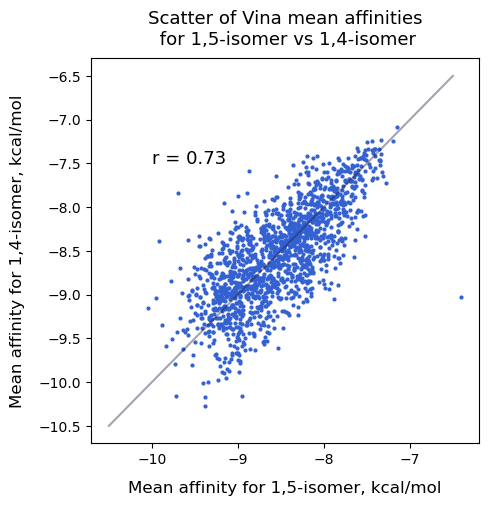

In [9]:
# plot scatter of 1,4-isomers mean affinities vs these for 1,5-isomers

pairs = np.array(pairs)

fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(x=pairs[:, 0], y=pairs[:, 1], s=4, color='#3461d2')

plt.title("Scatter of Vina mean affinities\n for 1,5-isomer vs 1,4-isomer", fontsize=13, pad=10)
plt.xlabel('Mean affinity for 1,5-isomer, kcal/mol', fontsize=12, labelpad=10)
plt.ylabel('Mean affinity for 1,4-isomer, kcal/mol', fontsize=12, labelpad=10)

X_plot = np.linspace(-10.5, -6.5, 100)
plt.plot(X_plot, X_plot, color='#1c193d', alpha=0.4) # line at 45 deg.

plt.text(-10, -7.5, 'r = 0.73', fontsize=13)

r, p = stats.pearsonr(pairs[:, 0], pairs[:, 1])
print(f'Correlation is {r}, with p-value being {p}')

# plt.savefig('vina_scatter_isomers.png', bbox_inches='tight', dpi=300)
plt.show()

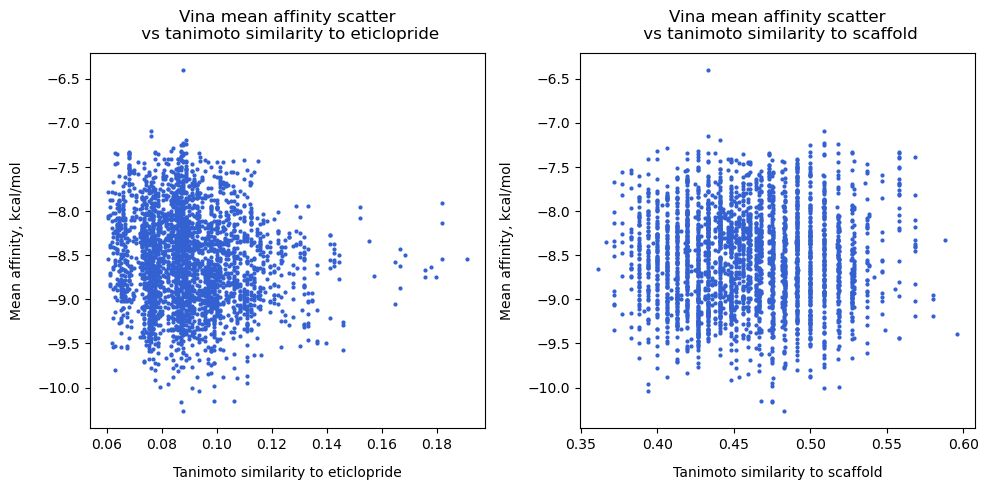

In [10]:
# plot affinity correlation to Tanimoto similarities

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

Y = click_library[click_library['id'].isin(list(data_vina.id))].epq_tanimoto

ax[0].scatter(x=Y, y=data_vina.affinity_mean, s=4, color='#3461d2')
ax[0].set_title("Vina mean affinity scatter\n vs tanimoto similarity to eticlopride", fontsize=12, pad=10)
ax[0].set_xlabel('Tanimoto similarity to eticlopride', fontsize=10, labelpad=10)
ax[0].set_ylabel('Mean affinity, kcal/mol', fontsize=10, labelpad=10)


Y = click_library[click_library['id'].isin(list(data_vina.id))].scaf_tanimoto

ax[1].scatter(x=Y, y=data_vina.affinity_mean, s=4, color='#3461d2')
ax[1].set_title("Vina mean affinity scatter\n vs tanimoto similarity to scaffold", fontsize=12, pad=10)
ax[1].set_xlabel('Tanimoto similarity to scaffold', fontsize=10, labelpad=10)
ax[1].set_ylabel('Mean affinity, kcal/mol', fontsize=10, labelpad=10)


plt.tight_layout()

# plt.savefig('vina_tanimoto.png', bbox_inches='tight', dpi=300)
plt.show()

<a id='section3'></a>
## iDock summary

In [11]:
# load and prepare data
data_idock = pd.read_csv('data/idock_data.csv', index_col=0)
print(data_idock.shape)
data_idock = data_idock[data_idock['idock_score'] != 0] # drop missing compounds
print(data_idock.shape)

# aggregate 
mean = data_idock.groupby(['id', 'isomer'])['idock_score'].mean().rename("affinity_mean")
std  = data_idock.groupby(['id', 'isomer'])['idock_score'].std().rename("affinity_std")
data_idock = pd.DataFrame(mean).join(std).reset_index()
print(f"Found data for {data_idock.shape[0]} molecules")

data_idock.head()

(9186, 5)
(9186, 5)
Found data for 3062 molecules


,id,isomer,affinity_mean,affinity_std
0,31,14,-8.453333,0.126623
1,32,15,-8.766667,0.005774
2,37,14,-8.003333,0.188237
3,38,15,-8.420000,0.030000
4,55,14,-8.210000,0.160000


In [12]:
data_idock = data_idock[data_idock['id'].isin(list(data_vina.id))]
print(f"Found data for {data_idock.shape[0]} molecules")

Found data for 3016 molecules


In [8]:
data_idock.describe()

,id,isomer,affinity_mean,affinity_std
count,3016.000000,3016.000000,3016.000000,3016.000000
mean,9498.534483,14.500000,-8.609914,0.104040
std,5474.837103,0.500083,0.539310,0.086034
min,31.000000,14.000000,-10.420000,0.000000
25%,4796.750000,14.000000,-9.010833,0.045092
50%,9345.500000,14.500000,-8.613333,0.079373
75%,14170.750000,15.000000,-8.223333,0.135277
max,18834.000000,15.000000,-7.123333,0.639557


**Here all compounds are present as iDock has parametrization for many other atoms. And also no outliers are found**

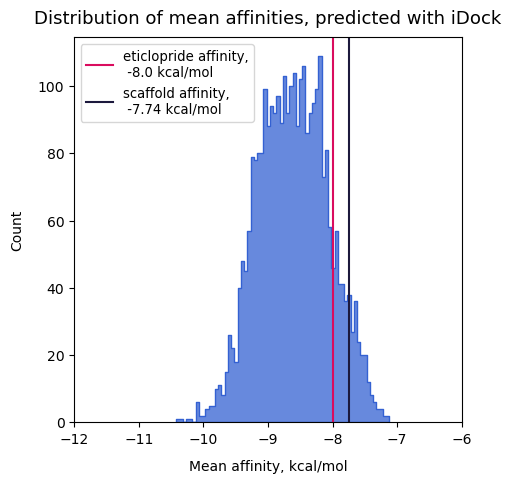

In [13]:
# plot destribution of iDock mean affinities

plt.figure(figsize=(5,5))

# lines representing eticlopide docking:  -8.0 +- 0.1
plt.axvline(x=-8.0, color='#da0c5e', label='eticlopride affinity,\n -8.0 kcal/mol')

# lines representing scaffold docking: -7.74 +- 0.04
plt.axvline(x=-7.74, color='#1c193d', label='scaffold affinity,\n -7.74 kcal/mol')

sns.histplot(data_idock['affinity_mean'], binwidth=0.05, color='#3461d2', element="step")

plt.xlabel("Mean affinity, kcal/mol", fontsize=10, labelpad=10) # Text for X-Axis
plt.ylabel("Count", fontsize=10, labelpad=10) # Text for Y-Axis
plt.title("Distribution of mean affinities, predicted with iDock", fontsize=13, pad=10)

plt.xlim(-12, -6)
plt.legend(loc = 'upper left', fontsize=9.5) # bbox_to_anchor=(1.1, 1.05)

# plt.savefig('idock_affinities_distplot.png', bbox_inches='tight', dpi=300)
plt.show()

230


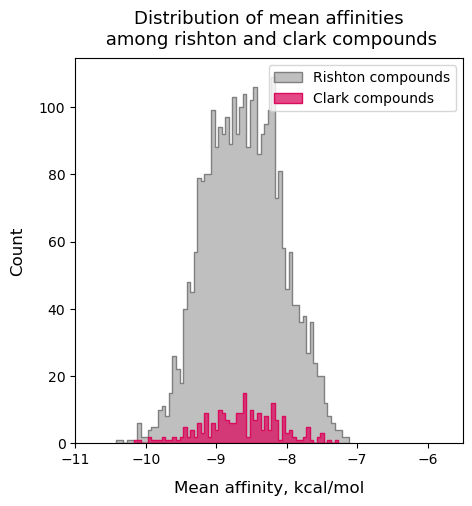

In [14]:
# hue destrubution by Clark and Rishton compounds

# get ids of clark compounds 
clark_id = list(click_library[click_library['group_clark'] == 1].id)
print(len(clark_id))

plt.figure(figsize=(5,5))

sns.histplot(data_idock['affinity_mean'], 
             color='grey', alpha=0.5, binwidth=0.05, element="step", label='Rishton compounds')


sns.histplot(data_idock[data_idock['id'].isin(clark_id)]['affinity_mean'],
             color='#da0c5e', binwidth=0.05, element="step", label='Clark compounds')


plt.xlabel("Mean affinity, kcal/mol", fontsize=12, labelpad=10) # Text for X-Axis
plt.ylabel("Count", fontsize=12, labelpad=10) # Text for Y-Axis
plt.title("Distribution of mean affinities\n among rishton and clark compounds", fontsize=13, pad=10)

plt.xlim(-11, -5.5)

plt.legend(loc='upper right')


# plt.savefig('idock_affinities_distplot_clark_vs_rishton.png', bbox_inches='tight', dpi=300)
plt.show()

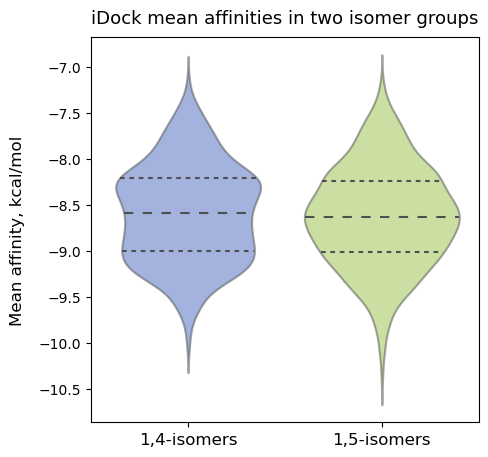

In [15]:
# compare affinities distributions for 1,4 and 1,5 isomers as violin plots

plt.figure(figsize=(5,5))

s = sns.violinplot(y='affinity_mean', x='isomer', data=data_idock,
               palette=['#3461d2', '#9fd432'], inner="quartile")

for violin in s.collections[::1]:
    violin.set_alpha(0.5)

s.set_xticklabels(labels=['1,4-isomers', '1,5-isomers'], fontsize=12)
plt.xlabel("")
plt.ylabel("Mean affinity, kcal/mol", fontsize=12, labelpad=10) # Text for Y-Axis
plt.title("iDock mean affinities in two isomer groups", fontsize=13, pad=10)

# plt.savefig('idock_affinities_violin_14_vs_15.png', bbox_inches='tight', dpi=300)
plt.show()

In [28]:
# sort 14 and 15 isomers for subsequents plots

pairs = []
pair = []
last_id = 0

def sort_value(i, isomer, affinty):
    global pairs, pair, last_id
    
    if isomer == 14:
        last_id = i
        pair = [affinty]
    else:
        if last_id + 1 == i:
            pair.append(affinty)
            pairs.append(pair.copy())
            pair = []
        else:
            last_id, pair = 0, []
    
data_idock.apply(lambda row: sort_value(row.id, row.isomer, row.affinity_mean), axis=1)
print(len(pairs))

1508


In [29]:
pairs = np.array(pairs)
data1 = pairs[:, 0]
data2 = pairs[:, 1]

# compare samples
stat, p = ttest_rel(data1, data2)
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Statistics=4.036, p=0.000
Different distributions (reject H0)


Correlation is 0.7803684320531453, with p-value being 2.241663235383813e-309


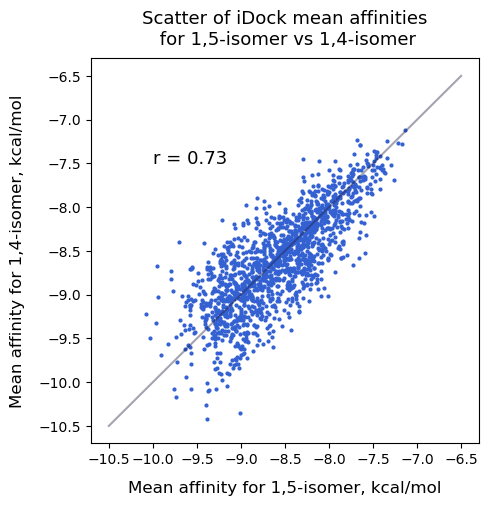

In [17]:
# plot scatter of 1,4-isomers mean affinities vs these for 1,5-isomers

pairs = np.array(pairs)

fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(x=pairs[:, 0], y=pairs[:, 1], s=4, color='#3461d2')

plt.title("Scatter of iDock mean affinities\n for 1,5-isomer vs 1,4-isomer", fontsize=13, pad=10)
plt.xlabel('Mean affinity for 1,5-isomer, kcal/mol', fontsize=12, labelpad=10)
plt.ylabel('Mean affinity for 1,4-isomer, kcal/mol', fontsize=12, labelpad=10)

X_plot = np.linspace(-10.5, -6.5, 100)
plt.plot(X_plot, X_plot, color='#1c193d', alpha=0.4) # line at 45 deg.

plt.text(-10, -7.5, 'r = 0.73', fontsize=13)

r, p = stats.pearsonr(pairs[:, 0], pairs[:, 1])
print(f'Correlation is {r}, with p-value being {p}')

# plt.savefig('idock_scatter_isomers.png', bbox_inches='tight', dpi=300)
plt.show()

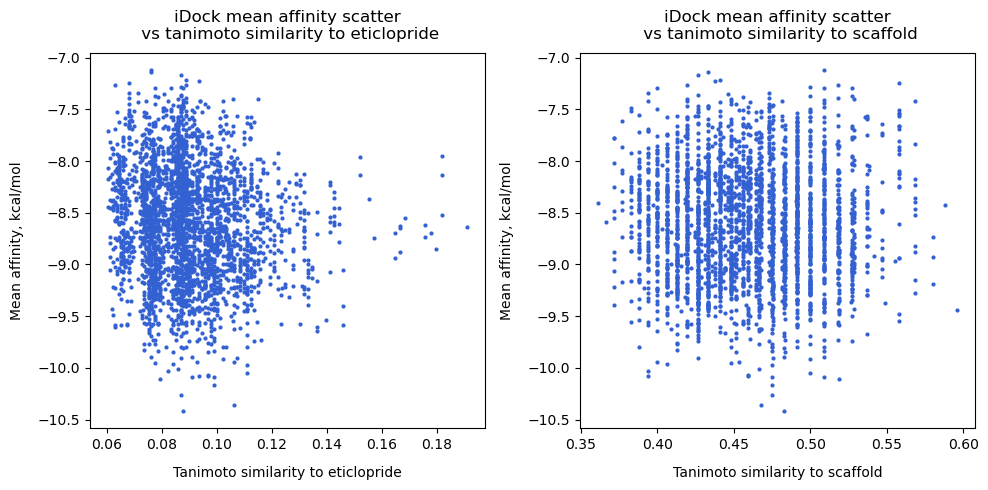

In [18]:
# plot affinity correlation to Tanimoto similarities

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

Y = click_library[click_library['id'].isin(list(data_idock.id))].epq_tanimoto

ax[0].scatter(x=Y, y=data_idock.affinity_mean, s=4, color='#3461d2')
ax[0].set_title("iDock mean affinity scatter\n vs tanimoto similarity to eticlopride", fontsize=12, pad=10)
ax[0].set_xlabel('Tanimoto similarity to eticlopride', fontsize=10, labelpad=10)
ax[0].set_ylabel('Mean affinity, kcal/mol', fontsize=10, labelpad=10)


Y = click_library[click_library['id'].isin(list(data_idock.id))].scaf_tanimoto

ax[1].scatter(x=Y, y=data_idock.affinity_mean, s=4, color='#3461d2')
ax[1].set_title("iDock mean affinity scatter\n vs tanimoto similarity to scaffold", fontsize=12, pad=10)
ax[1].set_xlabel('Tanimoto similarity to scaffold', fontsize=10, labelpad=10)
ax[1].set_ylabel('Mean affinity, kcal/mol', fontsize=10, labelpad=10)


plt.tight_layout()

# plt.savefig('idock_tanimoto.png', bbox_inches='tight', dpi=300)
plt.show()

<a id='section4'></a>
## iDock vs Vina comparison  
**Let's analyze how well iDock and Vina predictions are correlated**

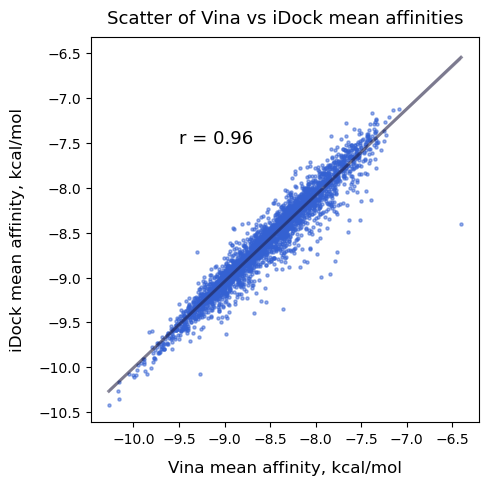

In [19]:
# Vina has less compounds than iDock
idock_filt = data_idock[data_idock['id'].isin(list(data_vina.id))]

# regplots
plt.figure(figsize=(5, 5))


# all compounds
sns.regplot(x=data_vina.affinity_mean,
            y=idock_filt.affinity_mean,
            line_kws={'color': '#1c193d', 'alpha': 0.5},
            scatter_kws={'alpha':0.5, 's': 5, 'color': '#3461d2'})

plt.text(-9.5, -7.5, 'r = 0.96', fontsize=13)

plt.title('Scatter of Vina vs iDock mean affinities', fontsize=13, pad=10)
plt.xlabel('Vina mean affinity, kcal/mol', fontsize=12, labelpad=10)
plt.ylabel('iDock mean affinity, kcal/mol', fontsize=12, labelpad=10)

# plt.savefig('idock_vs_vina_regplot.png', bbox_inches='tight', dpi=300)
plt.show()

<a id='section5'></a>
## Selection of best binders
**Let's compare top 20 binders from Vina and iDock to select best candidates**

In [18]:
# select top binders
vina_top = data_vina.sort_values(by='affinity_mean').head(20)
idock_top = data_idock.sort_values(by='affinity_mean').head(20)

common_id = set(vina_top.id).intersection(set(idock_top.id))

# intersect two sets
print(f"""There are {len(common_id)} common compounds. Common cmpounds ids are:
{common_id}""")

print(f"""Respective Vina scores are:
{[round(a, 2) for a in vina_top[vina_top['id'].isin(common_id)].affinity_mean]}""")

print(f"""Respective iDock scores are:
{[round(a, 2) for a in idock_top[idock_top['id'].isin(common_id)].affinity_mean]}""")

There are 17 common compounds. Common cmpounds ids are:
{2304, 1828, 134, 5126, 15848, 7788, 3949, 17806, 14418, 3700, 8213, 15382, 6133, 7000, 12379, 10844, 4830}
Respective Vina scores are:
[-10.27, -10.17, -10.16, -10.16, -10.04, -10.01, -10.0, -9.98, -9.96, -9.95, -9.92, -9.89, -9.88, -9.88, -9.87, -9.85, -9.81]
Respective iDock scores are:
[-10.42, -10.36, -10.26, -10.17, -10.11, -10.09, -10.08, -10.08, -10.07, -10.05, -10.03, -10.01, -9.98, -9.97, -9.96, -9.94, -9.91]


**Visualization:**

In [19]:
# a function to draw a panel of molecules with labels
def draw_molecules(molecules, legends, title):
    # Annotates a MolsToGridImage given a set of labels for each mol with better font size options and title
    sub_img_size = 500
    title_size = 25
    y_offset = -10
    mols_per_row = 5

    img = Draw.MolsToGridImage(molecules,
                               molsPerRow=mols_per_row,
                               subImgSize=(sub_img_size, sub_img_size),
                               returnPNG=False)
    
    height = 6 * (len(molecules)//4 + (len(molecules)%4 > 0)) + 10

    fig, ax = plt.subplots(figsize=(24,height))
    plt.title(title, fontsize=title_size)
    text_pos = (sub_img_size / 2, sub_img_size + y_offset)

    pos_ctr = 0
    plt.axis("off")
    for cmpd_text in legends:
        plt.annotate(cmpd_text, text_pos, fontsize=17, horizontalalignment='center')
        pos_ctr += 1
        text_pos = (text_pos[0] + sub_img_size, text_pos[1])
        if (pos_ctr % mols_per_row) == 0:
            text_pos = (sub_img_size / 2, text_pos[1] + sub_img_size)

    ax.imshow(img, origin="upper")

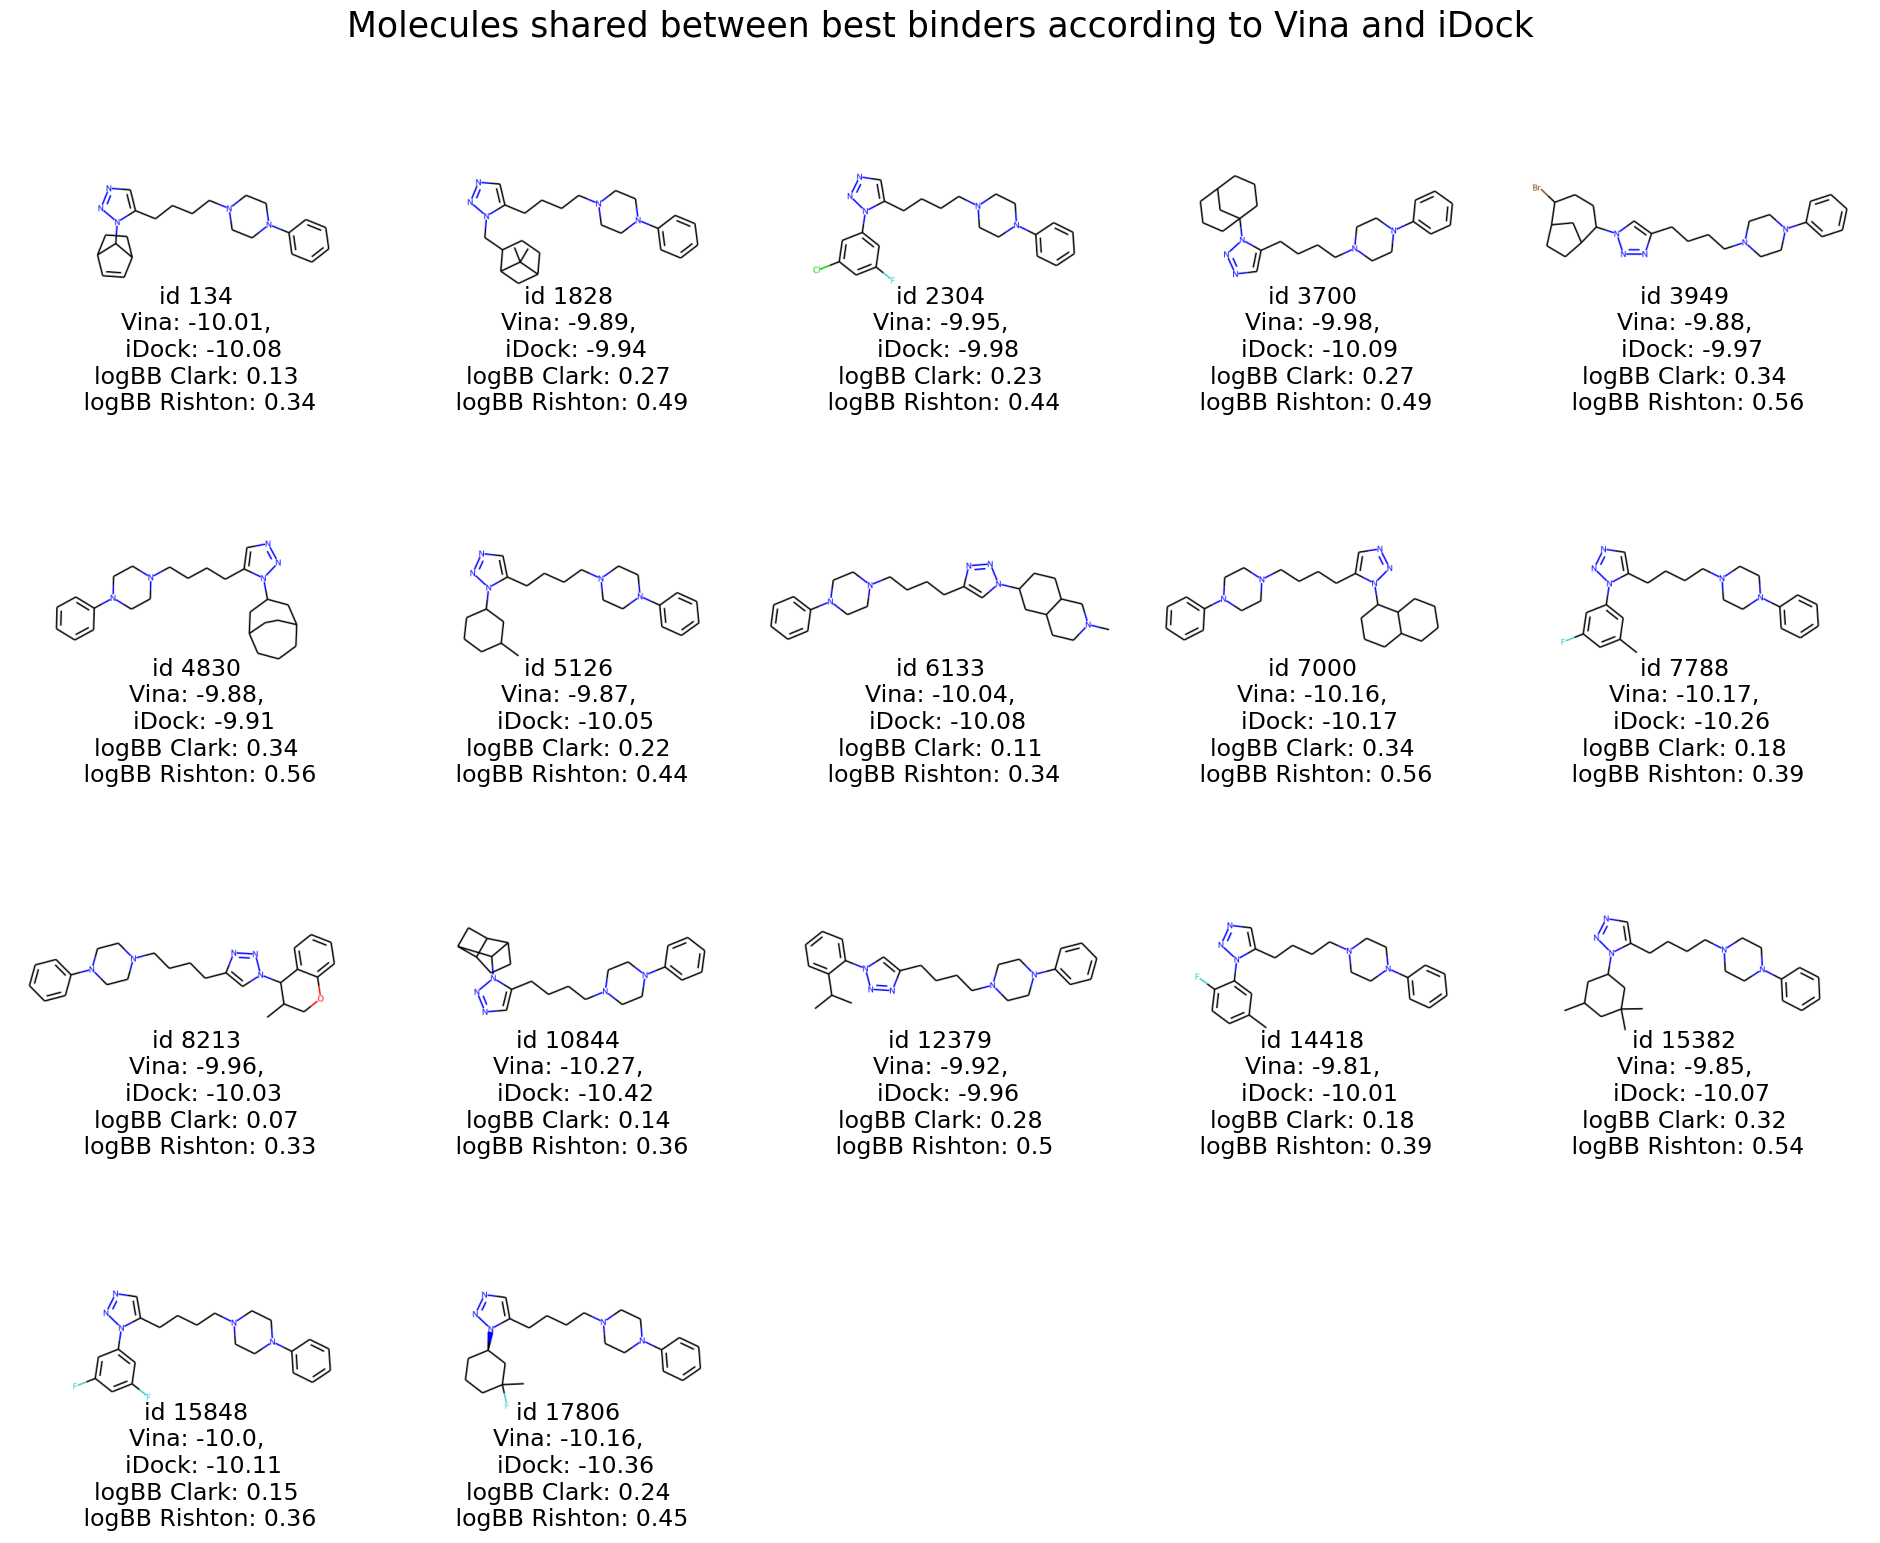

In [22]:
# compounds with high energies
mol_id = list(data_vina[data_vina['id'].isin(common_id)]['id'])

aff_vina = data_vina[data_vina['id'].isin(mol_id)]['affinity_mean'].round(2)
aff_idock = data_idock[data_idock['id'].isin(mol_id)]['affinity_mean'].round(2)

# get molecules to draw 
molecules = [Chem.MolFromSmiles(smi) for smi in click_library[click_library['id'].isin(mol_id)]['smiles']]

# logBB values
logbbc = click_library[click_library['id'].isin(mol_id)]['logBBclark'].round(2)
logbbr = click_library[click_library['id'].isin(mol_id)]['logBBrishton'].round(2)

# set legends
legends = [f'id {i}\nVina: {v},\n  iDock: {d}\nlogBB Clark: {c}\n logBB Rishton: {r}' for i, v, d, c, r in zip(mol_id, aff_vina, aff_idock, logbbc, logbbr)]

draw_molecules(molecules, legends, "Molecules shared between best binders according to Vina and iDock")

# plt.savefig('best_binders.png', bbox_inches='tight', dpi=300)
plt.show()

In [135]:
# write list of smiles
with open('data/top_binders.txt', 'w') as f:
    for ind in mol_id:
        f.write(f"{click_library[click_library['id'] == ind].id.values[0]}\t{click_library[click_library['id'] == ind].smiles.values[0]}\n")